***
# **<font color = 'brown'>Azure Cognitive Vision ArcGIS Online Functions</font>**
***

## **Preliminaries and Libraries**
---

Import the required libraries for the project

In [150]:
import os, io, geojson, json, http.client, requests, time, tqdm
from getpass import getpass
from datetime import datetime
from arcgis.gis import GIS
from arcgis.features import FeatureLayerCollection
from azure.storage.blob import BlockBlobService
from PIL import Image
from tqdm import tqdm
from ipywidgets import widgets
from IPython.display import display
http.client._MAXHEADERS = 5000

Define working directory and project path

In [151]:
computer = os.environ['COMPUTERNAME']
if computer == "SRVYGS046C":
    prjPath = r"C:\Users\OCPWAlexandridisK\source\repos\ktalexan\ML-Vision-Photospheres"
elif computer == "DRK01":
    prjPath = r"C:\Users\ktale\source\repos\ktalexan\ML-Vision-Photospheres"
os.chdir(prjPath)

## **Set global defaults and account access for the project**
---

### **<font color = 'green'>Azure Blob Storage</font>**

Setup account information for the Azure Blob Storage containing the photosphere cardinal (tagged) images.
The images were generated from the previous process in the *<font color='blue'>AzureCognitiveVisionRest.py'</font>* file.

Setup account and key for the Azure blob storage containing the photosphere images.

In [152]:
with open('credentialsAzure.json') as f:
    azcred = json.load(f)
    account_name = azcred['account']
    account_key = azcred['key']

In [153]:
blobService = BlockBlobService(account_name, account_key)

In [154]:
blobBaseUri = 'https://{}.blob.core.windows.net'.format(account_name)

> Function: **get_blob_list**

In [155]:
def get_blob_list(containerName):
    """Lists the blobs in the container
    This function generates a list of blobs (images) that exist within an Azure blob storage container.
    
    Arguments
        containerName: the name of the Azure blob storage container.
        
    Output
        blobList: the list of blobs (images) in the container
    """
    blobList = []
    generator = blobService.list_blobs(containerName)
    for blob in tqdm(generator):
        blobList.append(blob)
    return blobList

Generate the blob image list for the 'cardinal' storage container

In [156]:
blobList = get_blob_list('cardinal')


0it [00:00, ?it/s]
3232it [00:00, 646601.03it/s]

### **<font color = 'green'>ArcGIS Online</font>**

Get the account and token information for the ArcGIS online account

In [161]:
userArcGIS = 'ktalexan'
pswArcGIS = getpass()

 ··········


Create a gis object for the user 'ktalexan'

In [162]:
gis = GIS('https://www.arcgis.com', userArcGIS, pswArcGIS)

Get the token for the account

In [163]:
tokenUrl = 'https://www.arcgis.com/sharing/rest/generateToken'
params = {'f': 'pjson', 'username': userArcGIS, 'password': pswArcGIS, 'referer': 'https://www.arcgis.com', 'expiration': str(525600)}
response = requests.post(tokenUrl, data = params, verify = True)
token = response.json()['token']

Define user

<User username:ktalexan>
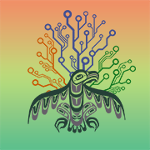

In [164]:
me = gis.users.me
me

Get user groups for the user

Member of 4 groups


<Group title:"OC CA" owner:ktalexan>

<Group title:"Machine Learning Photospheres" owner:ktalexan>
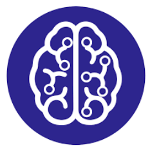

<Group title:"Orange County Open Data" owner:OCPublicWorks>
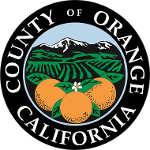

<Group title:"OC Geodemographic Group" owner:ktalexan>
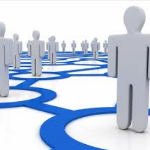

In [165]:
user_groups = me.groups
print('Member of {} groups'.format(str(len(user_groups))))
for group in user_groups:
    display(group)

Obtain a list of folders for the user

In [166]:
myfolders = me.folders
print('User {} is the owner of {} folders: '.format(me.username, str(len(myfolders))))
for i, folder in enumerate(myfolders):
    print('\t[{}]: {}'.format(i, folder['title']))

User ktalexan is the owner of 5 folders: 
	[0]: AzCognVision
	[1]: CA - Application Data
	[2]: CA - Project Data
	[3]: GeoDemographics
	[4]: KA ESRI Training


Get the properties of the *'AzCognVision'* folder:

In [167]:
for i, folder in enumerate(myfolders):
    if folder['title'] == 'AzCognVision':
        print('\nProperties of {} folder:'.format(folder['title']))
        for attr in folder:
            if attr == 'created':
                dt = datetime.fromtimestamp(folder[attr] /1e3)
                created = datetime.strftime(dt, '%m/%d/%Y %I:%M%p')
                print('\t[{}]: {}'.format(attr, created))
            else:
                print('\t[{}]: {}'.format(attr, folder[attr]))


Properties of AzCognVision folder:
	[username]: ktalexan
	[id]: 21c997cda3c64038831b3ed2d3df5735
	[title]: AzCognVision
	[created]: 03/02/2019 07:08AM


Set the *'AgCognVision'* as the working folder

In [168]:
workingfolder = [folder for folder in myfolders if folder['title'] == 'AzCognVision'][0]
print('\nMy working ArcGIS folder is {}'.format(workingfolder['title']))


My working ArcGIS folder is AzCognVision


List all the items in the working folder

In [169]:
myitems = me.items(folder = workingfolder)
print('Items in my working folder:')
for i, item in enumerate(myitems):
    print('\t[{}]: {} ({})'.format(i, item['title'], item['type']))

Items in my working folder:
	[0]: Web App - Azure Cognitive Vision Cardinal Photosphere Images (Web Mapping Application)
	[1]: Web App - Azure Cognitive Vision Cardinal Photosphere Images (Code Attachment)
	[2]: Web Map - Azure Cognitive Vision Cardinal Photosphere Images (Web Map)
	[3]: Dashboard - Azure Cognitive Vision Cardinal Photosphere Images (Dashboard)
	[4]: Azure Cognitive Vision Tagged Cardinal Photosphere Classification Analysis (Service Definition)
	[5]: Azure Cognitive Vision Tagged Cardinal Photosphere Classification Analysis (Feature Service)
	[6]: Google Cloud Vision Tagged Cardinal Photosphere Classification Analysis (Service Definition)
	[7]: Google Cloud Vision Tagged Cardinal Photosphere Classification Analysis (Feature Service)
	[8]: Web Map - Azure Cognitive Vision Tagged Cardinal Photosphere Images (Web Map)
	[9]: Web Map - Google Cloud Vision Tagged Cadinal Photosphere Images (Web Map)
	[10]: Dashboard - Google Cloud Vision Cardinal Photosphere Images (Dashboar

## **Processing cardinal images in ArcGIS online feature layer**
---

### **<font color = 'green'>Importing Cardinal Feature Collection GeoJSON to ArcGIS Online</font>**

Defining the filename (stored in working directory)

In [42]:
item_file = 'cardinalFeatureCollection.json'

Defining item properties basic metadata for ArcGIS online layer

In [43]:
item_properties = {
    'title': 'Azure Cognitive Vision Cardinal Photospheres Feature Collection',
    'tags': 'test, Azure Cognitive Vision, Machine Learning, Photospheres',
    'snippet': 'Azure Cognitive Vision Feature Collection for Tagged Cardinal Photosphere Images',
    'description': '<div style="text-align:Left;"><div><div><p><span>This layer contains image analysis results from </span><span style="font-weight:bold;"><font color="#008000">Azure Cognitive Services Computer Vision</font> </span><span>API run, for the </span><span style="font-weight:bold;"><font color="#b22222">tagged cardinal images (8 directions, 1000x1000)</font> </span><span>image parts from photospheres. The layer includes (embeds) the tagged (annotated) images as attachments.</span></p></div></div></div>',
    'licenseInfo': 'This is a test dataset only. Should not be used in production settings.',
    'accessInformation': 'This is a test dataset with programming under development. If you have any questions, contact Dr. Kostas Alexandridis for further details: Kostas.Alexandridis@ocpw.ocgov.com, (714) 967-0826',
    'type': 'GeoJson'
    }
thumb = 'geoJSON2.png'

Uploading the GeoJSON file, and creating the basic GeoJSON Feature Service

In [101]:
acvfs = gis.content.add(item_properties, thumbnail = thumb, data = item_file, folder = workingfolder['title'])

Publishing the uploaded feature service (GeoJSON) into a new feature layer collection

In [102]:
acvfsl = acvfs.publish()

In [130]:
gis.content.search('Azure Cognitive Vision Cardinal Photospheres Feature Collection', 'Feature Layer')

[<Item title:"Azure Cognitive Vision Cardinal Photospheres Feature Collection" type:Feature Layer Collection owner:ktalexan>,
 <Item title:"Azure Cognitive Vision Tagged Cardinal Photosphere Classification Analysis" type:Feature Layer Collection owner:ktalexan>]

In [131]:
acvflc = gis.content.search('Azure Cognitive Vision Cardinal Photospheres Feature Collection', 'Feature Layer')[0]

<Item title:"Azure Cognitive Vision Cardinal Photospheres Feature Collection" type:Feature Layer Collection owner:ktalexan>
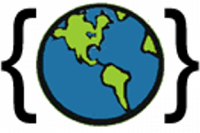

In [132]:
acvflc

Obtain the individual layer of the published feature layer collection

In [133]:
acvfl = acvflc.layers[0]

Query the initial capabilities of the layer

In [134]:
acvfl.properties.capabilities

'Create,Delete,Query,Update,Editing'

Update the layer's capabilities (if the capabilities are not 'Create,Delete,Query,Update,Editing') to enable editing and other operations.

In [123]:
update_dict = {'capabilities': 'Create,Delete,Query,Update,Editing'}

In [124]:
acvfl.manager.update_definition(update_dict)

{'success': True}

>Function: **add_lyr_attachments_from_blob**(*container, layer*)

When this function is executed, it adds all 3,232 cardinal images as an attachment to the GeoJSON-based feature layer hosted in ArcGIS online. If needed, all attachments can be deleted.

In [135]:
def add_lyr_attachments_from_blob(container, layer):
    """Adding attachments to ArcGIS feature layer from Azure blob images
    This function:
        1. Gets the blob list (images) from a blob storage container in Azure.
        2. For each of the blobs in the blob list, it obtains the image, and saves it
            temporarily in the notebook's project directory. The reason for this is that
            the Python API for adding attachments in a feature (hosted) layer only takes
            filepath as an argument.
        3. Performs a matching query, i.e., matching the cardinal image name from the
            blob list with the feature (hosted) layer's record containing the image name,
            and returning the ObjectId for that layer's table.
        4. Finally, it uploads and adds the temporarily saved image as an attachment to
            the record with the obtained ObjectId (OID).

    Arguments
        container: the name of the Azure blob storage container.
        layer: the hosted feature layer in ArcGIS online

    Output
        Nothing. Just adds the blob images as attachments to the hosted ArcGIS online
        feature layer.
    """
    blobList = get_blob_list(container)
    noblobs = len(blobList)
    for blob in tqdm(blobList):
        blobName = blob.name
        content = blobService.get_blob_to_bytes(container, blobName).content
        img = Image.open(io.BytesIO(content))
        img.save(blobName, 'JPEG')
        query = layer.query(where = "Cardinal_Image_Name LIKE '{}'".format(blobName), out_fields = 'ObjectId')
        oid = query.features[0].attributes['ObjectId']
        layer.attachments.add(oid, blobName)
        os.remove(blobName)

Add the attachments to the layer (run once only)

In [142]:
add_lyr_attachments_from_blob('cardinal', acvfl)

3232it [00:00, 807721.54it/s]
 46%|████▌     | 1475/3232 [34:46<42:22,  1.45s/it]

KeyboardInterrupt: 

Let's query the feature set now

In [136]:
acvfset = acvfl.query()

Display the feature set as a panda (spatial) data frame

In [137]:
acvfset.sdf.head()

,Altitude,Caption,Caption_Confidence,Cardinal_Direction,Cardinal_Direction_Label,Cardinal_Image_Name,Cardinal_Image_URL,Cardinal_Number,Category_Detail_1,Category_Detail_2,...,x3,x4,x5,x6,y1,y2,y3,y4,y5,y6
0,31.69103,a car driving down a street next to a tree,0.947685,354.51680,N,181204_174945407_1_N.jpg,https://azmlstorageblob.blob.core.windows.net/...,1,{'landmarks': []},None,...,NaN,NaN,NaN,NaN,710.0,NaN,NaN,NaN,NaN,NaN
1,31.69103,a house that has a sign on the side of a road,0.947707,39.51682,NE,181204_174945407_2_NE.jpg,https://azmlstorageblob.blob.core.windows.net/...,2,{'landmarks': []},{'landmarks': []},...,NaN,NaN,NaN,NaN,710.0,NaN,NaN,NaN,NaN,NaN
2,31.69103,a car parked on the side of a building,0.925620,84.51682,E,181204_174945407_3_E.jpg,https://azmlstorageblob.blob.core.windows.net/...,3,{'landmarks': []},{'landmarks': []},...,NaN,NaN,NaN,NaN,612.0,NaN,NaN,NaN,NaN,NaN
3,31.69103,a group of palm trees,0.970518,129.51680,SE,181204_174945407_4_SE.jpg,https://azmlstorageblob.blob.core.windows.net/...,4,{'landmarks': []},{'landmarks': []},...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,31.69103,a view of a city street,0.880143,174.51680,S,181204_174945407_5_S.jpg,https://azmlstorageblob.blob.core.windows.net/...,5,{'landmarks': []},{'landmarks': []},...,NaN,NaN,NaN,NaN,544.0,653.0,NaN,NaN,NaN,NaN


Getting the features of the layer

In [138]:
acvfeat = acvfset.features

In [139]:
acvfeat[0].attributes['ObjectId']

1

Creating a copy of the features for updating

In [140]:
rev_acvfeat = acvfeat

Define the base URL for the feature layer

In [141]:
baseUrl = acvfl.url

Use the objectId (OID) and the attributeId (AID) to create a URL link for each attached image

In [ ]:
acvfset.